**MSc Final Project**

Inherited Retinal Disease Literature Summarisation using Transformers

BART-based Transformer
Implementation

In [1]:
# !python -m spacy download en_core_web_md

In [2]:
# !pip install transformers

In [3]:
# !pip install sentencepiece

In [4]:
import os
import re
import torch
import transformers
import spacy
from tqdm import tqdm
from transformers import BartForConditionalGeneration, BartTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BartForConditionalGeneration, BartTokenizer
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import numpy as np

/mnt/data/skanda/mambaforge/envs/gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def load_preprocessed_data(directory):
    abstracts = []
    main_texts = []
    filenames = []

    # Loop through files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('_abstract.txt'):
            # Get the base filename without the '_abstract.txt' suffix
            base_filename = filename.replace('_abstract.txt', '')

            # Identify potential matching main text file(s)
            possible_main_text_files = [
                f for f in os.listdir(directory)
                if f.startswith(base_filename) and f.endswith('_main_text.txt')
            ]

            if possible_main_text_files:
                # Load the abstract
                with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                    abstract = file.read().strip()
                    abstracts.append(abstract)

                # Load the corresponding main text
                main_text_file = possible_main_text_files[0]
                with open(os.path.join(directory, main_text_file), 'r', encoding='utf-8') as file:
                    main_text = file.read().strip()
                    main_texts.append(main_text)

                # Store the base filename for reference
                filenames.append(base_filename)
            else:
                print(f"Warning: No corresponding main text file found for {filename}.")
    
    # Ensure the function returns the three lists
    print(f"Loaded {len(abstracts)} preprocessed documents.")
    return abstracts, main_texts, filenames


In [6]:
from transformers import BartTokenizer, BartForConditionalGeneration, T5Tokenizer, T5ForConditionalGeneration, GPT2Tokenizer, GPT2LMHeadModel
import torch

def generate_summary(model_name, text, device, max_length=1024, min_length=800, num_beams=4):
    # Load the appropriate model and tokenizer
    if model_name == "facebook/bart-large-cnn":
        tokenizer = BartTokenizer.from_pretrained(model_name)
        model = BartForConditionalGeneration.from_pretrained(model_name)
    elif model_name.startswith("t5"):
        tokenizer = T5Tokenizer.from_pretrained(model_name)
        model = T5ForConditionalGeneration.from_pretrained(model_name)
    elif model_name.startswith("gpt2"):
        tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        model = GPT2LMHeadModel.from_pretrained(model_name)
    else:
        raise ValueError("Unsupported model: {}".format(model_name))
    
    # Move the model to the device only once
    model.to(device)

    try:
        if model_name.startswith("t5"):
            input_text = "summarize: " + text
        else:
            input_text = text

        # Encode and move inputs to the device
        inputs = tokenizer.encode_plus(input_text[:1000], return_tensors="pt").to(device)
        text_length = len(inputs['input_ids'][0])
        
        if model_name.startswith("gpt2"):
            summary_ids = model.generate(
                inputs['input_ids'],
                max_new_tokens=150,
                num_beams=num_beams,
                early_stopping=True,
                pad_token_id=tokenizer.eos_token_id
            )
        else:
            target_summary_length = max(int(text_length * 0.2), min_length)
            target_summary_length = min(target_summary_length, max_length)

            summary_ids = model.generate(
                inputs['input_ids'], 
                max_length=target_summary_length,
                min_length=min_length, 
                length_penalty=2.0, 
                num_beams=num_beams,  # Use the provided num_beams value here
                early_stopping=True
            )
        
        # Decode the generated tokens into a summary
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return summary
    except Exception as e:
        print(f"Error in generating summary with {model_name}: {str(e)}")
        return ""


In [7]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

def evaluate_summary(reference, hypothesis):
    smoothie = SmoothingFunction().method4
    bleu_score = sentence_bleu([reference.split()], hypothesis.split(), smoothing_function=smoothie)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, hypothesis)
    return bleu_score, rouge_scores


In [8]:
from tqdm import tqdm

def process_papers(model_name, preprocessed_data, reference_summaries, num_beams=4):
    assert len(preprocessed_data) == len(reference_summaries), "Mismatch between number of papers and abstracts"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    summaries = []
    bleu_scores = []
    rouge_scores_list = []

    for doc, ref in zip(preprocessed_data, reference_summaries):
        if not ref:
            print(f"Skipping document with no abstract: {doc[:30]}...")
            continue

        summary = generate_summary(model_name, doc, device, num_beams=num_beams)
        bleu, rouge = evaluate_summary(ref, summary)

        summaries.append(summary)
        bleu_scores.append(bleu)
        rouge_scores_list.append(rouge)

    return summaries, bleu_scores, rouge_scores_list


In [9]:
import os

def save_results(summaries, bleu_scores, rouge_scores, filenames, results_dir):
    os.makedirs(results_dir, exist_ok=True)

    summaries_file = os.path.join(results_dir, 'summaries.txt')
    with open(summaries_file, 'w', encoding='utf-8') as f:
        for filename, summary in zip(filenames, summaries):
            f.write(f"Document: {filename}\n")
            f.write(summary + '\n\n')
    print(f"Summaries saved to {summaries_file}")

    scores_file = os.path.join(results_dir, 'scores.txt')
    with open(scores_file, 'w', encoding='utf-8') as f:
        for filename, bleu, rouge in zip(filenames, bleu_scores, rouge_scores):
            f.write(f"Document: {filename}\n")
            f.write(f"BLEU Score: {bleu:.4f}\n")
            f.write(f"ROUGE Scores: {rouge}\n\n")
    print(f"Scores saved to {scores_file}")

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot all model scores on the same graph for comparison
def plot_all_model_scores(model_scores_dict):
    plt.figure(figsize=(20, 10))

    # Plot BLEU Scores
    plt.subplot(2, 1, 1)
    for model_name, (bleu_scores, rouge_scores_list) in model_scores_dict.items():
        num_documents = len(bleu_scores)
        plt.plot(range(num_documents), bleu_scores, marker='o', linestyle='-', label=f'{model_name} BLEU')
    
    plt.xlabel('Document Index')
    plt.ylabel('BLEU Score')
    plt.title('BLEU Scores for Summarized Documents Across Models', fontweight='bold')
    plt.legend()
    plt.grid(True)

    # Plot ROUGE Scores
    plt.subplot(2, 1, 2)
    for model_name, (bleu_scores, rouge_scores_list) in model_scores_dict.items():
        rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores_list]
        rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores_list]
        rougel_scores = [score['rougeL'].fmeasure for score in rouge_scores_list]

        plt.plot(range(num_documents), rouge1_scores, marker='o', linestyle='-', alpha=0.6, label=f'{model_name} ROUGE-1')
        plt.plot(range(num_documents), rouge2_scores, marker='o', linestyle='-', alpha=0.6, label=f'{model_name} ROUGE-2')
        plt.plot(range(num_documents), rougel_scores, marker='o', linestyle='-', alpha=0.6, label=f'{model_name} ROUGE-L')

    plt.xlabel('Document Index')
    plt.ylabel('ROUGE Score')
    plt.title('ROUGE Scores for Summarized Documents Across Models', fontweight='bold')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [11]:
# Collect scores for each model in a dictionary
model_scores_dict = {}

model_names = ["facebook/bart-large-cnn", "t5-small", "gpt2"]
num_beams_values = [2, 4, 8]  # Experiment with these values
preprocessed_dir = '/mnt/data/skanda/MSc_IRD_LLM/data/data_separated'
results_dir = "/mnt/data/skanda/MSc_IRD_LLM/results"

for model_name in model_names:
    for num_beams in num_beams_values:
        print(f"Evaluating model: {model_name} with num_beams={num_beams}")
        
        # Load data
        abstracts, main_texts, filenames = load_preprocessed_data(preprocessed_dir)
        
        # Process data
        summaries, bleu_scores, rouge_scores_list = process_papers(model_name, main_texts, abstracts, num_beams=num_beams)
        
        # Store the scores in the dictionary
        experiment_name = f"{model_name}_num_beams_{num_beams}"
        model_scores_dict[experiment_name] = (bleu_scores, rouge_scores_list)

        # Save results
        model_results_dir = os.path.join(results_dir, experiment_name.replace("/", "_"))
        save_results(summaries, bleu_scores, rouge_scores_list, filenames, model_results_dir)

    # Print summaries
    print(f"Model: {model_name} - BLEU Score Summary:")
    print(f"Mean: {np.mean(bleu_scores):.4f}, Median: {np.median(bleu_scores):.4f}, Std Dev: {np.std(bleu_scores):.4f}")

    rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores_list]
    rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores_list]
    rougel_scores = [score['rougeL'].fmeasure for score in rouge_scores_list]

    print(f"Model: {model_name} - ROUGE-1 Score Summary:")
    print(f"Mean: {np.mean(rouge1_scores):.4f}, Median: {np.median(rouge1_scores):.4f}, Std Dev: {np.std(rouge1_scores):.4f}")

    print(f"Model: {model_name} - ROUGE-2 Score Summary:")
    print(f"Mean: {np.mean(rouge2_scores):.4f}, Median: {np.median(rouge2_scores):.4f}, Std Dev: {np.std(rouge2_scores):.4f}")

    print(f"Model: {model_name} - ROUGE-L Score Summary:")
    print(f"Mean: {np.mean(rougel_scores):.4f}, Median: {np.median(rougel_scores):.4f}, Std Dev: {np.std(rougel_scores):.4f}")



Evaluating model: facebook/bart-large-cnn with num_beams=2
Loaded 6 preprocessed documents.
Summaries saved to /mnt/data/skanda/MSc_IRD_LLM/results/facebook_bart-large-cnn_num_beams_2/summaries.txt
Scores saved to /mnt/data/skanda/MSc_IRD_LLM/results/facebook_bart-large-cnn_num_beams_2/scores.txt
Evaluating model: facebook/bart-large-cnn with num_beams=4
Loaded 6 preprocessed documents.
Summaries saved to /mnt/data/skanda/MSc_IRD_LLM/results/facebook_bart-large-cnn_num_beams_4/summaries.txt
Scores saved to /mnt/data/skanda/MSc_IRD_LLM/results/facebook_bart-large-cnn_num_beams_4/scores.txt
Evaluating model: facebook/bart-large-cnn with num_beams=8
Loaded 6 preprocessed documents.


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Summaries saved to /mnt/data/skanda/MSc_IRD_LLM/results/facebook_bart-large-cnn_num_beams_8/summaries.txt
Scores saved to /mnt/data/skanda/MSc_IRD_LLM/results/facebook_bart-large-cnn_num_beams_8/scores.txt
Model: facebook/bart-large-cnn - BLEU Score Summary:
Mean: 0.0267, Median: 0.0290, Std Dev: 0.0132
Model: facebook/bart-large-cnn - ROUGE-1 Score Summary:
Mean: 0.2788, Median: 0.2838, Std Dev: 0.0542
Model: facebook/bart-large-cnn - ROUGE-2 Score Summary:
Mean: 0.0760, Median: 0.0797, Std Dev: 0.0155
Model: facebook/bart-large-cnn - ROUGE-L Score Summary:
Mean: 0.1390, Median: 0.1402, Std Dev: 0.0231
Evaluating model: t5-small with num_beams=2
Loaded 6 preprocessed documents.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Summaries saved to /mnt/data/skanda/MSc_IRD_LLM/results/t5-small_num_beams_2/summaries.txt
Scores saved to /mnt/data/skanda/MSc_IRD_LLM/results/t5-small_num_beams_2/scores.txt
Evaluating model: t5-small with num_beams=4
Loaded 6 preprocessed documents.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Summaries saved to /mnt/data/skanda/MSc_IRD_LLM/results/t5-small_num_beams_4/summaries.txt
Scores saved to /mnt/data/skanda/MSc_IRD_LLM/results/t5-small_num_beams_4/scores.txt
Evaluating model: t5-small with num_beams=8
Loaded 6 preprocessed documents.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Summaries saved to /mnt/data/skanda/MSc_IRD_LLM/results/t5-small_num_beams_8/summaries.txt
Scores saved to /mnt/data/skanda/MSc_IRD_LLM/results/t5-small_num_beams_8/scores.txt
Model: t5-small - BLEU Score Summary:
Mean: 0.0025, Median: 0.0024, Std Dev: 0.0017
Model: t5-small - ROUGE-1 Score Summary:
Mean: 0.1666, Median: 0.1738, Std Dev: 0.0533
Model: t5-small - ROUGE-2 Score Summary:
Mean: 0.0302, Median: 0.0341, Std Dev: 0.0099
Model: t5-small - ROUGE-L Score Summary:
Mean: 0.1138, Median: 0.1115, Std Dev: 0.0373
Evaluating model: gpt2 with num_beams=2
Loaded 6 preprocessed documents.
Summaries saved to /mnt/data/skanda/MSc_IRD_LLM/results/gpt2_num_beams_2/summaries.txt
Scores saved to /mnt/data/skanda/MSc_IRD_LLM/results/gpt2_num_beams_2/scores.txt
Evaluating model: gpt2 with num_beams=4
Loaded 6 preprocessed documents.
Summaries saved to /mnt/data/skanda/MSc_IRD_LLM/results/gpt2_num_beams_4/summaries.txt
Scores saved to /mnt/data/skanda/MSc_IRD_LLM/results/gpt2_num_beams_4/scores.t

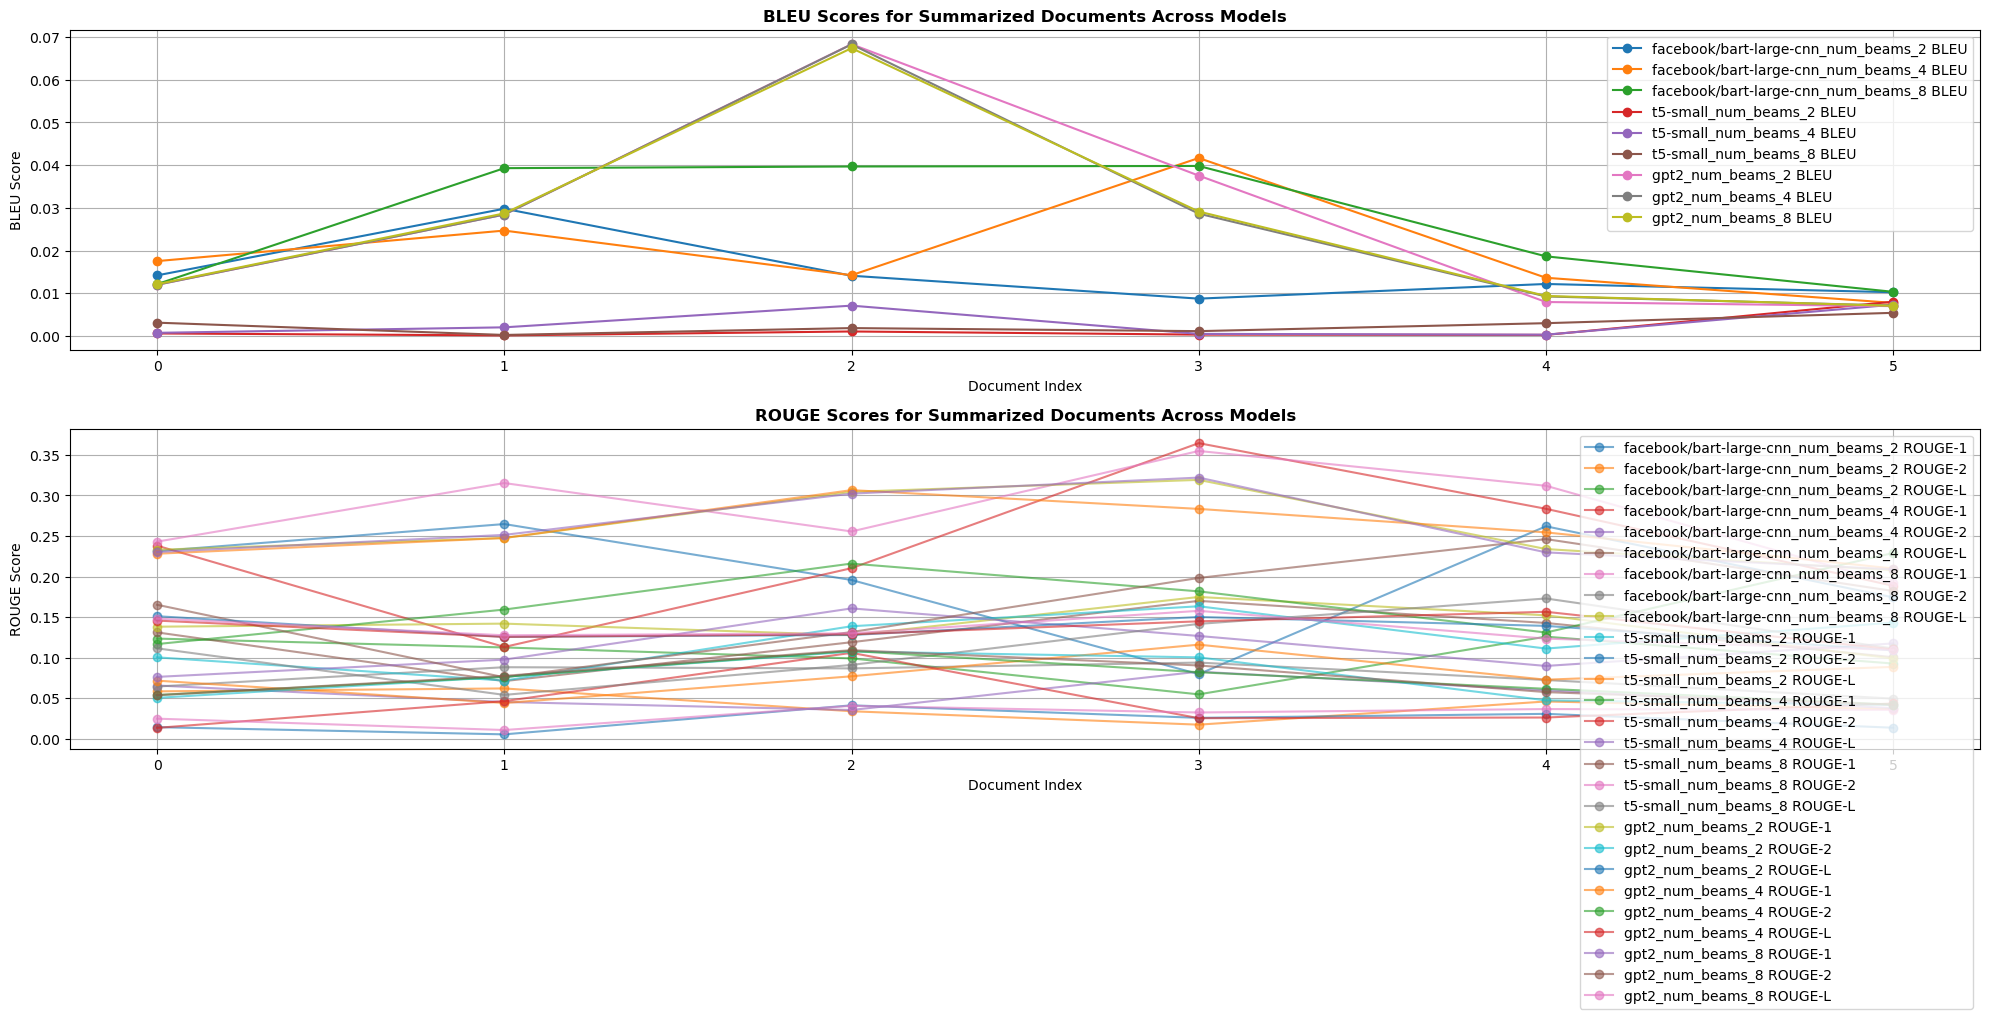

In [12]:
# Plot and compare scores across all models
plot_all_model_scores(model_scores_dict)

In [13]:
results_dir = "/mnt/data/skanda/MSc_IRD_LLM/results"

for model_name in model_names:
    model_results_dir = os.path.join(results_dir, model_name.replace("/", "_"))
    save_results(summaries, bleu_scores, rouge_scores_list, filenames, model_results_dir)


Summaries saved to /mnt/data/skanda/MSc_IRD_LLM/results/facebook_bart-large-cnn/summaries.txt
Scores saved to /mnt/data/skanda/MSc_IRD_LLM/results/facebook_bart-large-cnn/scores.txt
Summaries saved to /mnt/data/skanda/MSc_IRD_LLM/results/t5-small/summaries.txt
Scores saved to /mnt/data/skanda/MSc_IRD_LLM/results/t5-small/scores.txt
Summaries saved to /mnt/data/skanda/MSc_IRD_LLM/results/gpt2/summaries.txt
Scores saved to /mnt/data/skanda/MSc_IRD_LLM/results/gpt2/scores.txt


### **Evaluation**

In [14]:
# def extract_entities(text):
#     nlp = spacy.load('en_core_web_md')
#     doc = nlp(text)
#     # entities = [(ent.text, ent.label_) for ent in doc.ents]
#     return entities

# def evaluate_entity_coverage(original_text, summary_text):
#     original_entities = extract_entities(original_text)
#     summary_entities = extract_entities(summary_text)
    
#     original_entities_set = set([ent[0] for ent in original_entities])
#     summary_entities_set = set([ent[0] for ent in summary_entities])
    
#     coverage = len(original_entities_set & summary_entities_set) / len(original_entities_set)
#     print(f"Entity Coverage: {coverage:.2f}")
#     print(f"Original Entities: {original_entities}")
#     print(f"Summary Entities: {summary_entities}")
    
#     return coverage